# AABC cumulative recruitment stats and visuals


In [3]:
# check out  ~/cron/aabc_recruits.sh
#

In [4]:
#load some libraries
import pandas as pd
import seaborn as sns
from ccf.box import LifespanBox
import yaml
from functions import *
from config import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

In [5]:
print(date.today().strftime("%m/%d/%Y"))

06/29/2023


In [6]:
#load HCA inventory 
config = LoadSettings()
secret=pd.read_csv(config['config_files']['secrets'])
box = LifespanBox(cache="./tmp")
pathp=box.downloadFile(config['hcainventory'])
ids=pd.read_csv(pathp)

In [7]:
#load AABC report
aabcarms = redjson(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0])
hcpa = redjson(tok=secret.loc[secret.source=='hcpa','api_key'].reset_index().drop(columns='index').api_key[0])
#just a report
aabcreport = redreport(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0],reportid='51031')

#download the inventory report from AABC for comparison
aabcinvent=getframe(struct=aabcreport,api_url=config['Redcap']['api_url10'])


HTTP Status: 200


In [8]:
aabcinvent['todaydate']=date.today()
aabcinvent['dayspassed']=(pd.to_datetime(aabcinvent.todaydate) - pd.to_datetime(aabcinvent.v0_date)).dt.days


#get list of subjects who passed recruitment and registered for a visit
#for i in list(aabcinvent.columns):
#    print(i)
    
subjects=aabcinvent[['study_id','subject_id','redcap_event_name','passedscreen','register_subject_complete','register_visit_complete']]
#print(subjects.shape)
subjects=subjects.loc[subjects.register_visit_complete =='2'][['study_id']]
subs=list(subjects.study_id)


In [9]:

forplot=aabcinvent.loc[(aabcinvent.study_id.isin(subs)) & (aabcinvent.redcap_event_name.str.contains('register'))][['redcap_event_name','v0_date','dayspassed','age','sex','racial','ethnic','site','counterbalance_1st']]
forplot=forplot.sort_values('dayspassed')

#forplot.head()

In [10]:
#PREPARE DATA FOR PLOTS
#forplot['sexsum']=
S=pd.get_dummies(forplot.sex, prefix='sex')

#forplot['sexsum']=pd.to_numeric(forplot.sex, errors='coerce').cumsum()
forplot['malesum']=pd.to_numeric(S.sex_1, errors='coerce').cumsum()
forplot['femalesum']=pd.to_numeric(S.sex_2, errors='coerce').cumsum()
forplot['Sex']=forplot.sex.replace({'1':'Male','2':'Female'})

S0=pd.get_dummies(forplot.counterbalance_1st, prefix='CB')
forplot['CB3sum']=pd.to_numeric(S0.CB_3, errors='coerce').cumsum()
forplot['CB4sum']=pd.to_numeric(S0.CB_4, errors='coerce').cumsum()
forplot['Counterbalance']=forplot.counterbalance_1st.replace({'3':'CB3','4':'CB4'})



In [11]:
#forplot.redcap_event_name.value_counts()
forplot['Cohort']=''
forplot.loc[(forplot.redcap_event_name.str.contains("arm_1")) | (forplot.redcap_event_name.str.contains("arm_2")) |(forplot.redcap_event_name.str.contains("arm_3")) |(forplot.redcap_event_name.str.contains("arm_4")) ,'Cohort']='Cohort A'
forplot.loc[(forplot.redcap_event_name.str.contains("arm_5")) | (forplot.redcap_event_name.str.contains("arm_6")) |(forplot.redcap_event_name.str.contains("arm_7")) |(forplot.redcap_event_name.str.contains("arm_8")) ,'Cohort']='Cohort B'
forplot.loc[(forplot.redcap_event_name.str.contains("arm_9")) | (forplot.redcap_event_name.str.contains("arm_10")) |(forplot.redcap_event_name.str.contains("arm_11")) |(forplot.redcap_event_name.str.contains("arm_12")) ,'Cohort']='Cohort C'
#forplot.Cohort

In [12]:
#1, Native American/Alaskan Native | 2, Asian | 3, Black or African American | 4, Native Hawaiian or Other Pacific Is | 5, White | 6, More than one race | 99, Unknown or Not reported
S2=pd.get_dummies(forplot.racial, prefix='race')
#print(S2.head())
forplot['whitesum']=pd.to_numeric(S2.race_5, errors='coerce').cumsum()
#forplot['natpacsum']=pd.to_numeric(S2.race_4, errors='coerce').cumsum()
forplot['blacksum']=pd.to_numeric(S2.race_3, errors='coerce').cumsum()
forplot['asiansum']=pd.to_numeric(S2.race_2, errors='coerce').cumsum()
forplot['natamersum']=pd.to_numeric(S2.race_1, errors='coerce').cumsum()
forplot['moret1sum']=pd.to_numeric(S2.race_6, errors='coerce').cumsum()
forplot['nasum']=pd.to_numeric(S2.race_99, errors='coerce').cumsum()
forplot['Race']=forplot.racial.replace({'1':'Nat Amer/Alaskan','2':'Asian','3':'Black','4':'Nat Hawaiian/PI','5':'White','6':'More than one','99':'Unknown'})

#thnicity
S3=pd.get_dummies(forplot.ethnic, prefix='ethnicity')
forplot['hispanicsum']=pd.to_numeric(S3.ethnicity_1, errors='coerce').cumsum()
forplot['nonhispanicsum']=pd.to_numeric(S3.ethnicity_2, errors='coerce').cumsum()
forplot['unkhispsum']=pd.to_numeric(S3.ethnicity_3, errors='coerce').cumsum()
forplot['Ethnicity']=forplot.ethnic.replace({'1':'Hispanic','2':'Non-Hispanic','3':'Unknown'})

#sites
S4=pd.get_dummies(forplot.site, prefix='site')
forplot['wusum']=pd.to_numeric(S4.site_4, errors='coerce').cumsum()
forplot['umnsum']=pd.to_numeric(S4.site_3, errors='coerce').cumsum()
forplot['mghsum']=pd.to_numeric(S4.site_1, errors='coerce').cumsum()
forplot['uclasum']=pd.to_numeric(S4.site_2, errors='coerce').cumsum()
forplot['Site']=forplot.site.replace({'1':'MGH','2':'UCLA','3':'UMN','4':'WashU'})

In [13]:
                                       
##ages
bins= [30,40,50,60,70,80,90,125]

forplot['ages']=pd.to_numeric(forplot.age)
forplot['AgeGroup'] = pd.cut(forplot['ages'], bins=bins,right=False)# labels=labels,
S5=pd.get_dummies(forplot.AgeGroup, prefix='age')

forplot['age30sum']=pd.to_numeric(S5['age_[30, 40)'], errors='coerce').cumsum()
forplot['age40sum']=pd.to_numeric(S5['age_[40, 50)'], errors='coerce').cumsum()
forplot['age50sum']=pd.to_numeric(S5['age_[50, 60)'], errors='coerce').cumsum()
forplot['age60sum']=pd.to_numeric(S5['age_[60, 70)'], errors='coerce').cumsum()
forplot['age70sum']=pd.to_numeric(S5['age_[70, 80)'], errors='coerce').cumsum()
forplot['age80sum']=pd.to_numeric(S5['age_[80, 90)'], errors='coerce').cumsum()
forplot['age90sum']=pd.to_numeric(S5['age_[90, 125)'],errors='coerce').cumsum()

In [14]:
bins5= [35,40,45,50,55,60,65,70,75,80,85,90,125]

forplot['AgeGroup5'] = pd.cut(forplot['ages'], bins=bins5,right=False)# labels=labels,
S55=pd.get_dummies(forplot.AgeGroup5, prefix='age5')

forplot['age35sum5']=pd.to_numeric(S55['age5_[35, 40)'], errors='coerce').cumsum()
forplot['age40sum5']=pd.to_numeric(S55['age5_[40, 45)'], errors='coerce').cumsum()
forplot['age45sum5']=pd.to_numeric(S55['age5_[45, 50)'], errors='coerce').cumsum()
forplot['age50sum5']=pd.to_numeric(S55['age5_[50, 55)'], errors='coerce').cumsum()
forplot['age55sum5']=pd.to_numeric(S55['age5_[55, 60)'], errors='coerce').cumsum()
forplot['age60sum5']=pd.to_numeric(S55['age5_[60, 65)'], errors='coerce').cumsum()
forplot['age65sum5']=pd.to_numeric(S55['age5_[65, 70)'], errors='coerce').cumsum()
forplot['age70sum5']=pd.to_numeric(S55['age5_[70, 75)'], errors='coerce').cumsum()
forplot['age75sum5']=pd.to_numeric(S55['age5_[75, 80)'],errors='coerce').cumsum()
forplot['age80sum5']=pd.to_numeric(S55['age5_[80, 85)'],errors='coerce').cumsum()
forplot['age85sum5']=pd.to_numeric(S55['age5_[85, 90)'],errors='coerce').cumsum()
forplot['age90sum5']=pd.to_numeric(S55['age5_[90, 125)'],errors='coerce').cumsum()

#forplot.columns

### AABC Female participants, by age and cohort 

In [15]:
#make a table by cohort, 5-year age
#FeMALES
females=forplot.loc[forplot.Sex=='Female'].copy()
pd.crosstab(females.Cohort,females.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,5,5,2,11,11,9,10,8,8,9,3,81
Cohort B,2,5,2,7,14,13,6,8,3,2,0,62
Cohort C,1,0,0,0,1,1,0,1,0,0,0,4
All,8,10,4,18,26,23,16,17,11,11,3,147


### AABC Male participants, by age and cohort 

In [16]:
#make a table by cohort, 5-year age
males=forplot.loc[forplot.Sex=='Male'].copy()
pd.crosstab(males.Cohort,males.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,7,4,7,6,9,13,12,12,6,4,4,84
Cohort B,3,4,2,3,4,4,11,7,4,3,0,45
Cohort C,0,0,0,2,0,1,0,0,0,0,0,3
All,10,8,9,11,13,18,23,19,10,7,4,132


### Site stats , by age and cohort

In [17]:
#make a table by cohort, 5-year age
print("*******************")
print("**** MGH ONLY *****")
mgh=forplot.loc[forplot.Site=='MGH'].copy()
pd.crosstab(mgh.Cohort,mgh.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** MGH ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,5,3,2,3,8,9,6,5,5,4,1,51
Cohort B,1,0,1,2,3,0,2,1,0,1,0,11
All,6,3,3,5,11,9,8,6,5,5,1,62


In [18]:
#make a table by cohort, 5-year age
print("*******************")
print("**** UCLA ONLY *****")
ucla=forplot.loc[forplot.Site=='UCLA'].copy()
pd.crosstab(ucla.Cohort,ucla.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** UCLA ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)",All
Cohort,,,,,,,,,,,
Cohort A,3,1,2,6,4,2,4,2,1,1,26
Cohort B,0,0,1,1,1,0,1,0,0,1,5
All,3,1,3,7,5,2,5,2,1,2,31


In [19]:
print("*******************")
print("**** WU ONLY *****")
wu=forplot.loc[forplot.Site=='WashU'].copy()
pd.crosstab(wu.Cohort,wu.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** WU ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,3,4,2,6,4,8,8,11,5,5,4,60
Cohort B,1,3,0,3,5,10,8,7,7,2,0,46
Cohort C,1,0,0,2,1,2,0,1,0,0,0,7
All,5,7,2,11,10,20,16,19,12,7,4,113


In [20]:
print("*******************")
print("**** UMN ONLY *****")
umn=forplot.loc[forplot.Site=='UMN'].copy()
pd.crosstab(umn.Cohort,umn.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** UMN ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,1,1,3,2,4,3,4,2,3,3,2,28
Cohort B,3,6,2,4,9,7,6,7,0,1,0,45
All,4,7,5,6,13,10,10,9,3,4,2,73


### Progress report format

In [30]:
forplot.Ethnicity.value_counts()
#forplot.columns

Non-Hispanic    253
Hispanic         23
Unknown           3
Name: Ethnicity, dtype: int64

In [66]:
print("*******************")
print("**** Race x Sex in Non-Hispanics  *****")
nhisp=forplot.loc[forplot.Ethnicity=='Non-Hispanic'].copy()
pd.crosstab(nhisp.Race,nhisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#n=pd.crosstab(nhisp.Race,nhisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#n.to_csv('Non-Hispanic.csv')
#n

*******************
**** Race x Sex in Non-Hispanics  *****


Sex,Female,Male,All
Race,,,
Asian,4,7,11
Black,16,14,30
Nat Amer/Alaskan,2,1,3
White,114,95,209
All,136,117,253


In [67]:
print("*******************")
print("**** Race x Sex in Hispanics  *****")
hisp=forplot.loc[forplot.Ethnicity=='Hispanic'].copy()
pd.crosstab(hisp.Race,hisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#h=pd.crosstab(hisp.Race,hisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#h.to_csv('Hispanic.csv')
#h

*******************
**** Race x Sex in Hispanics  *****


Sex,Female,Male,All
Race,,,
Black,1,1,2
More than one,1,4,5
Nat Amer/Alaskan,0,1,1
Unknown,2,1,3
White,5,7,12
All,9,14,23


In [68]:
print("*******************")
print("**** Race x Sex for Unknown Ethnicities  *****")
unk=forplot.loc[forplot.Ethnicity=='Unknown'].copy()
pd.crosstab(unk.Race,unk.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#u=pd.crosstab(unk.Race,unk.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#u.to_csv('Unknown.csv')
#u

*******************
**** Race x Sex for Unknown Ethnicities  *****


Sex,Female,Male,All
Race,,,
Asian,0,1,1
White,2,0,2
All,2,1,3


### AABC Univariate Counts

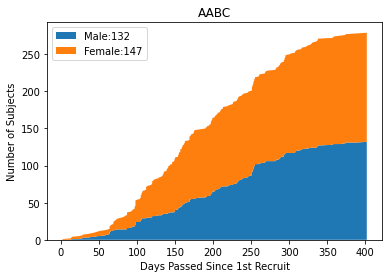

In [48]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.malesum) #[1,4,6,8,9]
y2=list(forplot.femalesum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['Male:'+str(max(y1)),'Female:'+str(max(y2))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');



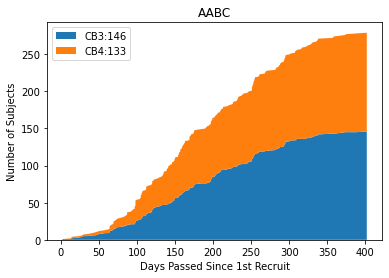

In [49]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.CB3sum) #[1,4,6,8,9]
y2=list(forplot.CB4sum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['CB3:'+str(max(y1)),'CB4:'+str(max(y2))])
plt.title("AABC")
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

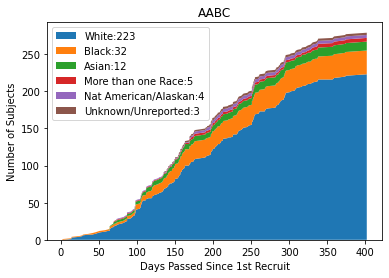

In [50]:
#BY RACE
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.whitesum) #[1,4,6,8,9]
y2=list(forplot.blacksum)#[2,2,7,10,12]
y3=list(forplot.asiansum)
y4=list(forplot.moret1sum)
#y5=list(forplot.natpacsum)
y6=list(forplot['natamersum'])
y7=list(forplot['nasum'])



# Basic stacked area chart.
plt.stackplot(x,y1,y2,y3,y4,y6,y7,labels=['White:'+str(max(y1)),'Black:'+str(max(y2)),'Asian:'+str(max(y3)),'More than one Race:'+str(max(y4)),'Nat American/Alaskan:'+str(max(y6)),'Unknown/Unreported:'+str(max(y7))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

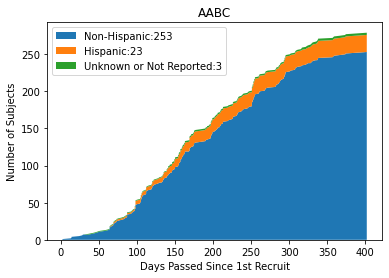

In [51]:
#BY ETHNICITY
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.nonhispanicsum) #[1,4,6,8,9]
y2=list(forplot.hispanicsum)#[2,2,7,10,12]
y3=list(forplot.unkhispsum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, labels=['Non-Hispanic:'+str(max(y1)),'Hispanic:'+str(max(y2)),'Unknown or Not Reported:'+str(max(y3))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

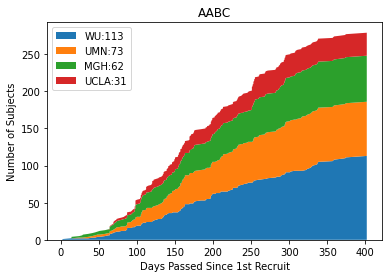

In [52]:
#By Site
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.wusum) #[1,4,6,8,9]
y2=list(forplot.umnsum)#[2,2,7,10,12]
y3=list(forplot.mghsum)
y4=list(forplot.uclasum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, y4,labels=['WU:'+str(max(y1)),'UMN:'+str(max(y2)),'MGH:'+str(max(y3)),'UCLA:'+str(max(y4))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');


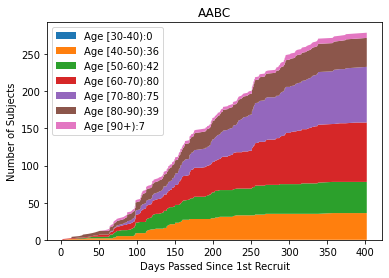

In [53]:
#By Age Bin
x=list(forplot.dayspassed) #range(1,6)
y2=list(forplot.age30sum)#[2,2,7,10,12]
y3=list(forplot.age40sum)
y4=list(forplot.age50sum)
y5=list(forplot.age60sum)
y6=list(forplot.age70sum)
y7=list(forplot.age80sum)
y8=list(forplot.age90sum)

# Basic stacked area chart.
plt.stackplot(x,y2,y3,y4,y5,y6,y7,y8, labels=['Age [30-40):'+str(max(y2)),'Age [40-50):'+str(max(y3)),'Age [50-60):'+str(max(y4)),'Age [60-70):'+str(max(y5)),'Age [70-80):'+str(max(y6)),'Age [80-90):'+str(max(y7)),'Age [90+):'+str(max(y8))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

### AABC Crosstabulations


Site,MGH,UCLA,UMN,WashU
Race,,,,
Asian,3,4,5,0
Black,9,3,7,13
More than one,0,3,0,2
Nat Amer/Alaskan,0,1,1,2
Unknown,1,1,1,0
White,49,19,59,96


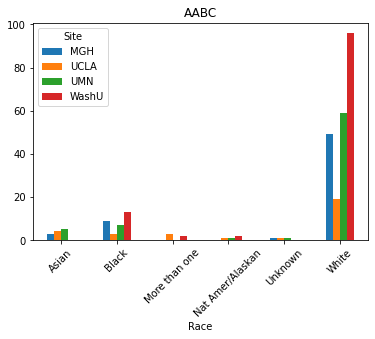

In [54]:
#Crosstabs x Site

pd.crosstab(forplot.Race,forplot.Site).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Ethnicity,,,,
Hispanic,4,12,5,2
Non-Hispanic,58,18,66,111
Unknown,0,1,2,0


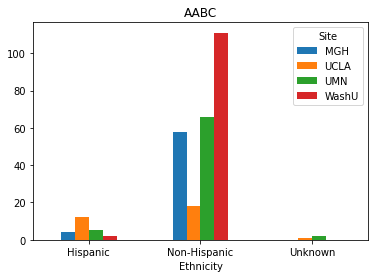

In [55]:
pd.crosstab(forplot.Ethnicity,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Ethnicity,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Site)

Site,MGH,UCLA,UMN,WashU
AgeGroup,,,,
"[40, 50)",9,4,11,12
"[50, 60)",8,10,11,13
"[60, 70)",20,7,23,30
"[70, 80)",14,7,19,35
"[80, 90)",10,3,7,19
"[90, 125)",1,0,2,4


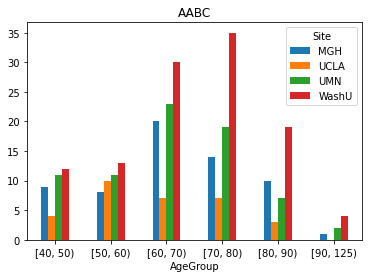

In [56]:
pd.crosstab(forplot.AgeGroup,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Sex,,,,
Female,29,11,45,62
Male,33,20,28,51


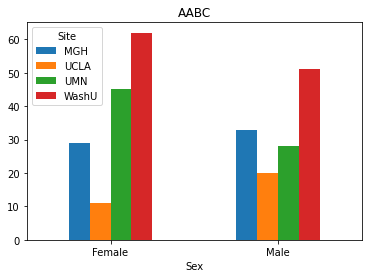

In [57]:
pd.crosstab(forplot.Sex,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Sex,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Sex,forplot.Site)

Race,Asian,Black,More than one,Nat Amer/Alaskan,Unknown,White
AgeGroup,,,,,,
"[40, 50)",3,9,1,1,0,22
"[50, 60)",3,10,1,2,2,24
"[60, 70)",4,8,2,1,1,64
"[70, 80)",0,5,1,0,0,69
"[80, 90)",2,0,0,0,0,37
"[90, 125)",0,0,0,0,0,7


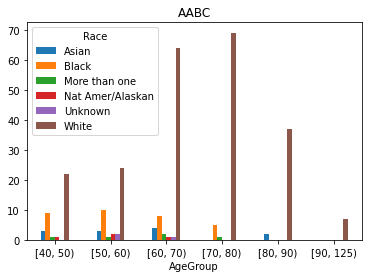

In [58]:
pd.crosstab(forplot.AgeGroup,forplot.Race).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Race).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Race)

Ethnicity,Hispanic,Non-Hispanic,Unknown
AgeGroup,,,
"[40, 50)",4,31,1
"[50, 60)",10,31,1
"[60, 70)",5,74,1
"[70, 80)",4,71,0
"[80, 90)",0,39,0
"[90, 125)",0,7,0


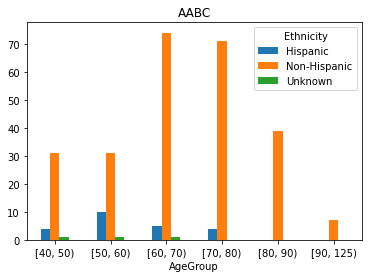

In [59]:
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity)


Sex,Female,Male
AgeGroup,,
"[40, 50)",18,18
"[50, 60)",22,20
"[60, 70)",49,31
"[70, 80)",33,42
"[80, 90)",22,17
"[90, 125)",3,4


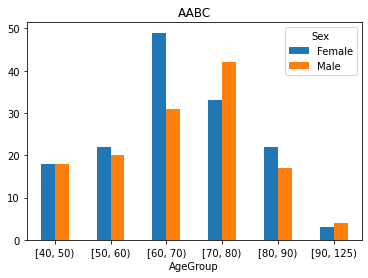

In [60]:
pd.crosstab(forplot.AgeGroup,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Sex)

Sex,Female,Male
Race,,
Asian,4,8
Black,17,15
More than one,1,4
Nat Amer/Alaskan,2,2
Unknown,2,1
White,121,102


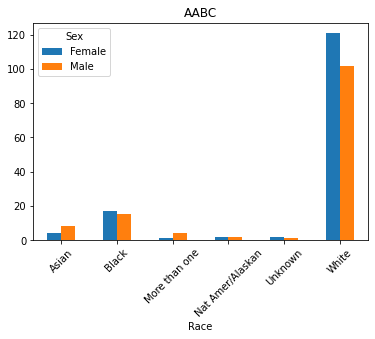

In [61]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Sex).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Sex)

Sex,Female,Male
Ethnicity,,
Hispanic,9,14
Non-Hispanic,136,117
Unknown,2,1


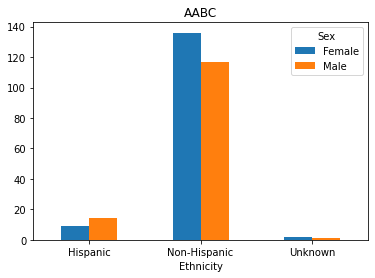

In [62]:
#Crosstabs
pd.crosstab(forplot.Ethnicity,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Ethnicity,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Sex)

Sex,Female,Male
Counterbalance,,
CB3,76,70
CB4,71,62


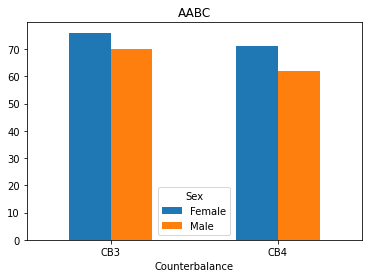

In [63]:
#Crosstabs
pd.crosstab(forplot.Counterbalance,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Counterbalance,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Counterbalance,forplot.Sex)

Counterbalance,CB3,CB4
Race,,
Asian,4,8
Black,18,14
More than one,4,1
Nat Amer/Alaskan,3,1
Unknown,1,2
White,116,107


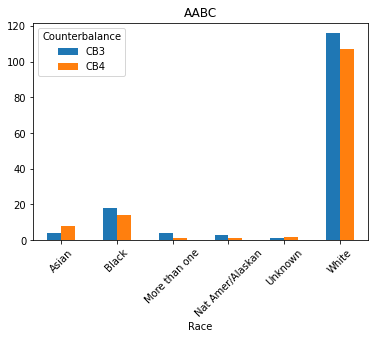

In [64]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Counterbalance).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Counterbalance)

Counterbalance,CB3,CB4
AgeGroup,,
"[40, 50)",21,15
"[50, 60)",26,16
"[60, 70)",36,44
"[70, 80)",36,39
"[80, 90)",22,17
"[90, 125)",5,2


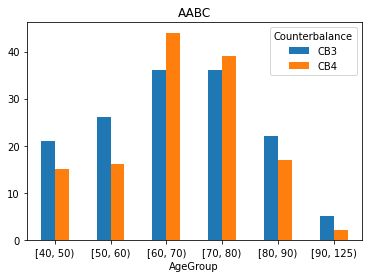

In [65]:
#Crosstabs
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance)